## FRB090625

FRB verification criteria.

Criteria results:

* POSTIVE: good evidence for astrophysical origin
* NEUTRAL: neutral evidence
* UNKNOWN: unknown from reported data
* NEGATIVE: evidence for terrestrial origin (non-critical)
* CRITICAL: good evidence for terrestiral origin (critical)
* NOTVALID: not valid criterion for observation

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lmfit
import cPickle as pkl

import astropy.time
import astropy.coordinates
import astropy.units

import dedispersion
import filterbankio
import frbutils
import scatterutils

%matplotlib inline

In [11]:
sns.set()
sns.set_context("notebook", rc={"lines.linewidth": 1.0})

In [12]:
criteria = {} # criteria status dictionary

### Parameters

[Five new Fast Radio Bursts from the HTRU high latitude survey: first evidence for two-component bursts - Champion et al.](https://arxiv.org/abs/1511.07746)

[Data Link](https://data-portal.hpc.swin.edu.au/dataset/fast-radio-burst-data-high-time-resolution-universe-survey-high-latitude)

Data Extraction:

```
boltflash:
cd /data2/griffin/FRB090625/FRB090625/06
extract 2009-06-25-21:50:31.fil 3015625 156250 > FRB090625_s193r10_b06.fil
decimate -c 1 -t 1 -n 8 FRB090625_s193r10_b06.fil > FRB090625_s193r10b8_b06.fil
```

In [13]:
frbStr = 'FRB090625'
#frbFil = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b06.fil' # Filterbank file of FRB event (aslxlap07)
frbFil = '/home/griffin/data/FRB/FRB090625/FRB090625_s193r10b8.fil' # Filterbank file of FRB event (watermark)

### Dynamic Spectrum (Component Optimized)

In [14]:
### dynamic spectrum parameters
timeFactor = 1
freqFactor = 1
dm = 899.5

start_time = 7.3 # seconds
time_window = 0.15 # seconds

applyGauss = True
fGauss = 4. # bins
tGauss = 4. # bins

rfi = [[805,820], [850,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

In [15]:
decwaterfall, decddwaterfall, tInt, freqs = frbutils.dynamicSpectrum(frbFil, start_time, time_window,
                                                timeFactor=timeFactor, freqFactor=freqFactor,
                                                dm=dm,
                                                applyGauss=applyGauss, fGauss=fGauss, tGauss=tGauss,
                                                rfi=rfi)

#### DM Excess

Using https://www.nrl.navy.mil/rsd/RORF/ne2001/

Galactic pointing: (l, b) = (226.444, -60.0303)

In [16]:
DM_galaxy = 31.69
DM_excess = dm / DM_galaxy
print 'DM Excess fraction:', DM_excess

DM Excess fraction: 28.3843483749


In [17]:
criteria['DMexcess'] = 'POSITIVE'

#### TIme Series

In [18]:
ddTimeSeries = np.mean(decddwaterfall, axis=1)

#### Stokes I Plot

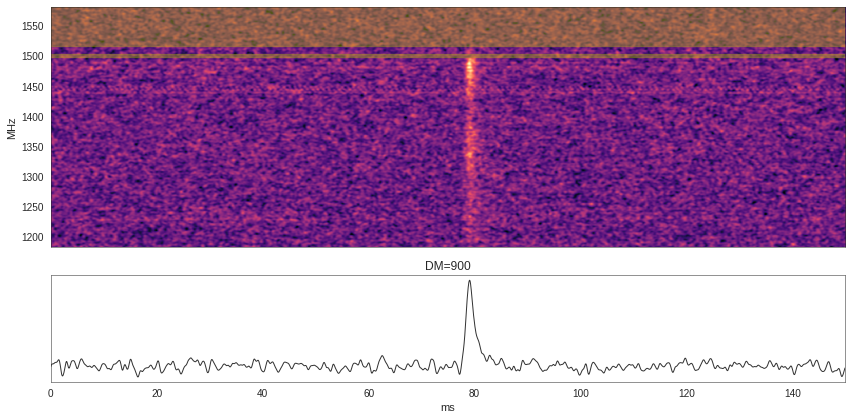

In [19]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)

imRaw = plt.imshow(np.flipud(decddwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
# crop out RFI flagged high freqs
#imRaw = plt.imshow(np.flipud(decddwaterfall[:,:850].T), extent=(0, tInt*decddwaterfall.shape[0],\
#                        freqs[0], freqs[850]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
lineColor = 'k'
plt.plot(1000.*tInt*np.arange(decddwaterfall.shape[0]), ddTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
plt.title('DM=%0.f'%dm)
plt.xlabel('ms')
ax2.get_yaxis().set_visible(False)

plt.tight_layout()
plt.savefig('%s_dynamic.png'%frbStr)

#### Signal to Noise

In [20]:
SNR = (ddTimeSeries.max() - ddTimeSeries.mean()) / ddTimeSeries.std()
print 'S/N:', SNR

S/N: 9.76147317455


In [21]:
criteria['SNR'] = 'POSITIVE' # high S/N across the band

#### Boresight Flux

In [22]:
SEFD = 30. # Jy, approximate SEFD of Parkes L-band
flux = frbutils.flux(SEFD, SNR, 1, 2, tInt, (freqs[-1]-freqs[0])*1e6)
print 'flux: %f Jy'%flux

flux: 1.294833 Jy


In [23]:
criteria['flux'] = 'POSITIVE' # high S/N across the band

#### Components

[[Model]]
    (Model(constant) + Model(gaussian, prefix='nc0'))
[[Fit Statistics]]
    # function evals   = 110
    # data points      = 700
    # variables        = 4
    chi-square         = 700.092
    reduced chi-square = 1.006
    Akaike info crit   = 8.092
    Bayesian info crit = 26.296
[[Variables]]
    c:              147.671501 +/- 0.039845 (0.03%) (init= 0)
    nc0sigma:       0.79968047 +/- 0.014336 (1.79%) (init= 1)
    nc0center:      27.9946850 +/- 0.014092 (0.05%) (init= 0)
    nc0amplitude:   34.2833708 +/- 0.549962 (1.60%) (init= 1)
    nc0fwhm:        1.88310356 +/- 0.033760 (1.79%)  == '2.3548200*nc0sigma'
    nc0height:      17.1031897 +/- 0.262536 (1.54%)  == '0.3989423*nc0amplitude/max(1.e-15, nc0sigma)'
[[Correlations]] (unreported correlations are <  0.100)
    C(nc0sigma, nc0amplitude)    =  0.597 
    C(c, nc0amplitude)           = -0.308 
    C(c, nc0sigma)               = -0.184 

NCOMPONENTS: 1
FWHM0 (ms): 1.88310356651


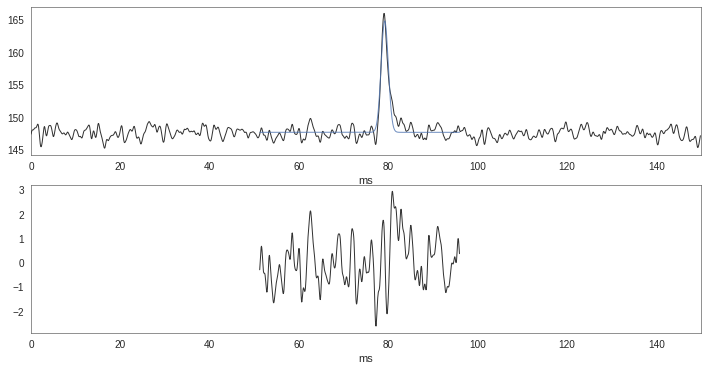

In [24]:
# Assume pulse can be modelled as a set of Gaussian components on a constant offset
nComponents = 1 # number of components in pulse

pulseModel = lmfit.models.ConstantModel()
for nc in np.arange(nComponents):
    gaussComp = lmfit.models.GaussianModel(prefix='nc%i'%nc)
    pulseModel += gaussComp

#print pulseModel
#params = pulseModel.make_params(nc0center=70., nc0sigma=6)
params = pulseModel.make_params()

#select only region around pulse for fit
tIdx0 = 800
tIdx1 = 1500
ddTimeSeriesCent = ddTimeSeries[tIdx0:tIdx1]
result = pulseModel.fit(ddTimeSeriesCent, params, x=1000.*tInt*np.arange(ddTimeSeriesCent.shape[0]))
print result.fit_report()

fig = plt.figure(figsize=(12,6)) # (width, height)

ax1 = plt.subplot(2,1,1)
lineColor = 'k'
plt.plot(1000.*tInt*np.arange(ddTimeSeries.shape[0]), ddTimeSeries, lineColor, alpha=0.8)
plt.plot(1000.*tInt*(np.arange(ddTimeSeriesCent.shape[0])+tIdx0), result.best_fit, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
plt.xlabel('ms')

ax2 = plt.subplot(2,1,2)
lineColor = 'k'
plt.plot(1000.*tInt*(np.arange(ddTimeSeriesCent.shape[0])+tIdx0), ddTimeSeriesCent - result.best_fit,\
         lineColor, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
plt.xlabel('ms')

print 'NCOMPONENTS:', nComponents
for nc in np.arange(nComponents):
    print 'FWHM%i (ms):'%nc, result.params['nc%ifwhm'%nc].value

In [25]:
criteria['pulsewidth'] = 'POSITIVE' # good fit to a Gaussian model
criteria['multicomp'] = 'POSITIVE' # single component

### Polarization

In [26]:
criteria['polarization'] = 'NOTVALID' # not recorded

### Spectral Index

In [27]:
# upper and lower frequency of pulse
# if pulse goes to the edge of beam, set to None
upperFreqMHz = freqs[850]
lowerFreqMHz = freqs[0]
obsFracBand = (freqs[-1]-freqs[0]) / ((freqs[-1]+freqs[0])/2.) # observational fractional bandwidth
print 'START OBS FREQ (MHz):', freqs[0]
print 'STOP OBS FREQ (MHz):', freqs[-1]
print 'BANDWIDTH (MHz):', freqs[-1]-freqs[0]
print 'FRACTIONAL OBS BANDWIDTH:', obsFracBand
print 'FRACTIONAL PULSE BANDWIDTH:', (upperFreqMHz - lowerFreqMHz) / ((upperFreqMHz+lowerFreqMHz)/2.)

START OBS FREQ (MHz): 1182.1953125
STOP OBS FREQ (MHz): 1581.8046875
BANDWIDTH (MHz): 399.609375
FRACTIONAL OBS BANDWIDTH: 0.289152948625
FRACTIONAL PULSE BANDWIDTH: 0.246275446048


In [28]:
criteria['broadband'] = 'POSITIVE'

In [29]:
# region to use for spectral index fit

# select between freq limits
upperFreqIdx = np.argmin(np.abs(freqs - upperFreqMHz))
lowerFreqIdx = np.argmin(np.abs(freqs - lowerFreqMHz))

# select around peak
peakIdx = np.unravel_index(np.argmax(decddwaterfall), decddwaterfall.shape)
tWidth = 10 # number of time stample to take on eiter side of peak

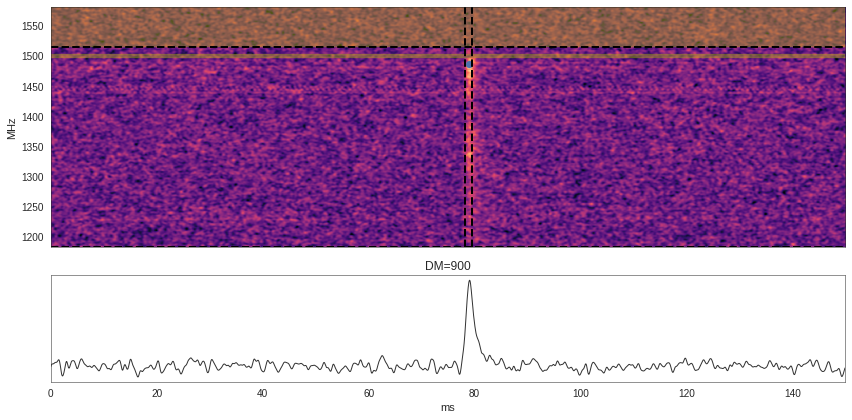

In [30]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)

imRaw = plt.imshow(np.flipud(decddwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
# crop out RFI flagged high freqs
#imRaw = plt.imshow(np.flipud(decddwaterfall[:,:850].T), extent=(0, tInt*decddwaterfall.shape[0],\
#                        freqs[0], freqs[850]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')
plt.axhline(y=upperFreqMHz, c='k', lw=2, ls='--')
plt.axhline(y=lowerFreqMHz, c='k', lw=2, ls='--')
plt.scatter(tInt*peakIdx[0], freqs[peakIdx[1]])
plt.axvline(x=tInt*(peakIdx[0]-tWidth), c='k', lw=2, ls='--')
plt.axvline(x=tInt*(peakIdx[0]+tWidth), c='k', lw=2, ls='--')

ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
lineColor = 'k'
plt.plot(1000.*tInt*np.arange(decddwaterfall.shape[0]), ddTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
plt.title('DM=%0.f'%dm)
plt.xlabel('ms')
ax2.get_yaxis().set_visible(False)

plt.tight_layout()

[[Model]]
    (Model(constant) + Model(powerlaw))
[[Fit Statistics]]
    # function evals   = 6378
    # data points      = 835
    # variables        = 3
    chi-square         = 51023.154
    reduced chi-square = 61.326
    Akaike info crit   = 3440.024
    Bayesian info crit = 3454.206
[[Variables]]
    c:          -290.395852 +/- 3.62e+03 (1246.85%) (init= 0)
    exponent:    0.18262121 +/- 1.450475 (794.25%) (init= 1)
    amplitude:   9.82544397 +/- 376.9971 (3836.95%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(exponent, amplitude)       = -1.000 
    C(c, amplitude)              = -1.000 
    C(c, exponent)               =  1.000 

SPECTRAL INDEX: 0.1826212102


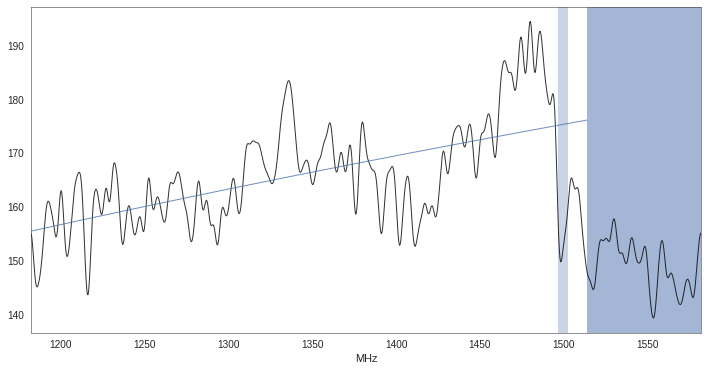

In [31]:
spectralRaw = decddwaterfall[peakIdx[0]-tWidth:peakIdx[0]+tWidth].mean(axis=0)

vaildFreqMask = np.zeros_like(spectralRaw)
vaildFreqMask[lowerFreqIdx:upperFreqIdx] = 1.
for freqPair in rfi:
    vaildFreqMask[freqPair[0]:freqPair[1]] = 0.

spectralModel = lmfit.models.ConstantModel() + lmfit.models.PowerLawModel()
spectralParams = spectralModel.make_params()
spectralResult = spectralModel.fit(spectralRaw[vaildFreqMask.astype(bool)],\
                                   spectralParams, x=freqs[vaildFreqMask.astype(bool)]*1e6)
print spectralResult.fit_report()

fig = plt.figure(figsize=(12,6)) # (width, height)

lineColor = 'k'
plt.plot(freqs, spectralRaw, lineColor, alpha=0.8)
plt.plot(freqs[vaildFreqMask.astype(bool)], spectralResult.best_fit, alpha=0.8)

plt.axvspan(freqs[0], freqs[lowerFreqIdx], alpha=0.3)
plt.axvspan(freqs[upperFreqIdx], freqs[-1], alpha=0.3)
for freqPair in rfi:
    plt.axvspan(freqs[freqPair[0]/freqFactor], freqs[freqPair[1]/freqFactor], alpha=0.3)

plt.xlabel('MHz')
plt.xlim(freqs[0], freqs[-1])

print 'SPECTRAL INDEX:', spectralResult.params['exponent'].value

In [32]:
criteria['spectralIndex'] = 'NEUTRAL' # variation across the band

### High-resolution Structure

In [33]:
### dynamic spectrum parameters
timeFactor = 1
freqFactor = 1
dm = 899.5

start_time = 7.3 # seconds
time_window = 0.15 # seconds

applyGauss = True
fGauss = 1. # bins
tGauss = 1. # bins

rfi = [[805,820], [850,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

In [34]:
decwaterfall, decddwaterfall, tInt, freqs = frbutils.dynamicSpectrum(frbFil, start_time, time_window,
                                                timeFactor=timeFactor, freqFactor=freqFactor,
                                                dm=dm,
                                                applyGauss=applyGauss, fGauss=fGauss, tGauss=tGauss,
                                                rfi=rfi)

In [35]:
ddTimeSeries = np.mean(decddwaterfall, axis=1)

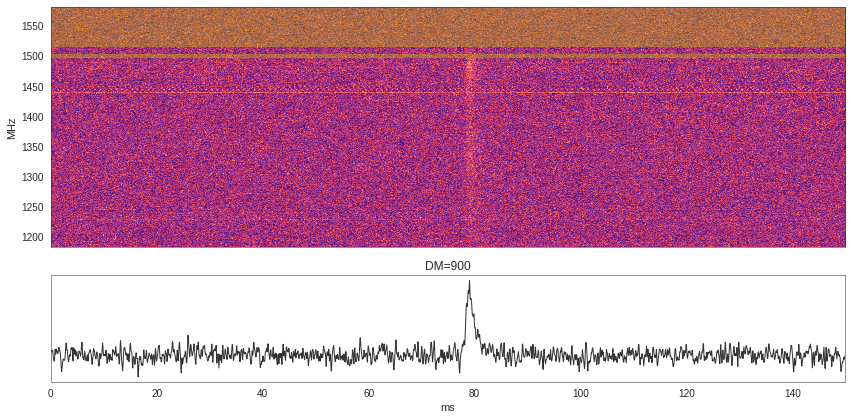

In [36]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)

imRaw = plt.imshow(np.flipud(decddwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
lineColor = 'k'
plt.plot(1000.*tInt*np.arange(decddwaterfall.shape[0]), ddTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
plt.title('DM=%0.f'%dm)
plt.xlabel('ms')
ax2.get_yaxis().set_visible(False)

plt.tight_layout()

In [37]:
criteria['highResStruct'] = 'POSITIVE' # no apparent structure

### Scattering

In [38]:
### Write dynamic spectrum to ascii file using a pdv-like method (writePDVtimeSeries)
### nch determines the number of channels to which a scattering time (tau value) is fitted
pdvfilen = '%s.ascii' %frbFil
pdvfile = scatterutils.writePDVtimeSeries(decddwaterfall, freqs, time_window, nch=4, src='FRB', ofn=pdvfilen) 

Pulsar name: FRB
Number of channels: 4
Number of bins: 2343
RMS: 0.229841
Using Tsub in header to convert bins to time. Note Tsub here is full phase time, corresponding to nbins.

 Channel 0
peak bin at lowest freq channel:1235
Rolling data by --63 bins
[[Model]]
    Model(GxETrain)
[[Fit Statistics]]
    # function evals   = 1963
    # data points      = 2343
    # variables        = 5
    chi-square         = 105.129
    reduced chi-square = 0.045
    Akaike info crit   = -7262.665
    Bayesian info crit = -7233.869
[[Variables]]
    mu:      1053.21707 +/- 2.350335 (0.22%) (init= 1172)
    sigma:   1.33586018 +/- 3.228748 (241.70%) (init= 15)
    A:       17.3478450 +/- 42.03792 (242.32%) (init= 1.18353)
    tau:     295.942122 +/- 65.10433 (22.00%) (init= 200)
    dc:     -0.06708207 +/- 0.006147 (9.16%) (init= 0)
    nbins:   2343 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma, A)                  = -0.997 
    C(tau, dc)                   = -0.565 
  

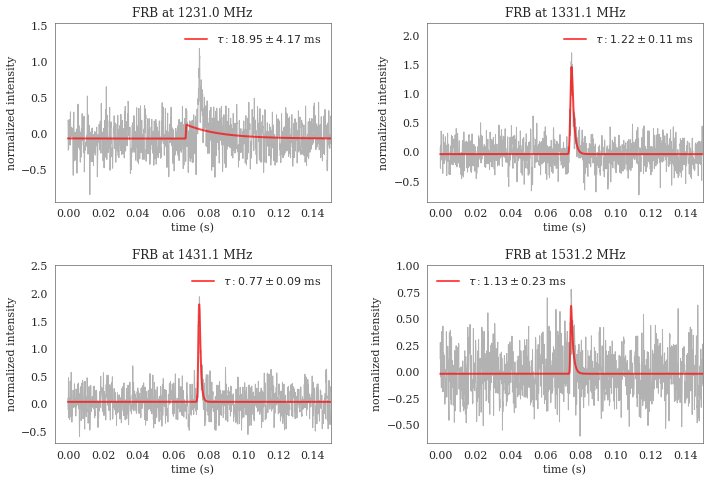

Tau (ms): 18.95
tau1GHz_alpha_4 (ms) ~ 43.50 

Tau (ms): 1.22
tau1GHz_alpha_4 (ms) ~ 3.84 

Tau (ms): 0.77
tau1GHz_alpha_4 (ms) ~ 3.25 

Tau (ms): 1.13
tau1GHz_alpha_4 (ms) ~ 6.20 



In [39]:
### produce_taufits 
### provides lmfit scattering fits (using intrinsic Gaussian shape) for each 'nch'
### method='iso' uses the standard ISM broadening function propto (1/tau)e^(-t/tau)

freqMHz, taus, tauserr = scatterutils.produce_taufits(pdvfilen,meth='iso')

In [40]:
tauserr_nonzero = tauserr[np.nonzero(tauserr)]

In [41]:
taus = taus[np.nonzero(tauserr)]
taus

array([ 0.01894636,  0.00122349,  0.00077389,  0.00112704])

[[Variables]]
    exponent:   -5.85267566 +/- 1.617295 (27.63%) (init=-12.57299)
    amplitude:   0.00644398 +/- 0.003420 (53.08%) (init= 0.1178774)
[[Correlations]] (unreported correlations are <  0.100)
    C(exponent, amplitude)       = -0.994 


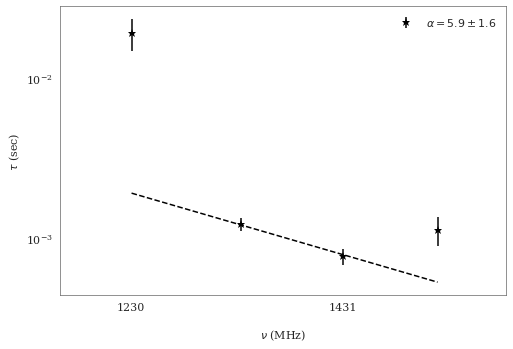

In [42]:
### produce_tauspectrum
### lmfit power law fit (weighted: 1/tauerr^2) for all non-zero tauerr
import scatterutils as scat
alpha, alphaerr = scat.produce_tauspectrum(freqMHz, taus, tauserr)

In [43]:
criteria['scattering'] = 'POSITIVE' # fit scattering tail

### Scintillation

In [44]:
criteria['scintillation'] = 'NEUTRAL' # no apparent scintillation

### DM Trial Space

In [45]:
# High-res
timeFactor = 8

minDM = 885.
maxDM = 915.
dmStep = 0.2

start_time = 7. # seconds
time_window = 1.5 # seconds

applyGauss = True
fGauss = 2. # bins
tGauss = 2. # bins

rfi = [[805,820], [850,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

In [46]:
dmSpaceArr, tInt, freqs = frbutils.dmSpace(frbFil, start_time, time_window,
                                          minDM, maxDM, dmStep, timeFactor, rfi=rfi)

Maximum delay (ms) based on maximum DM (915.000000): 1199.38528286


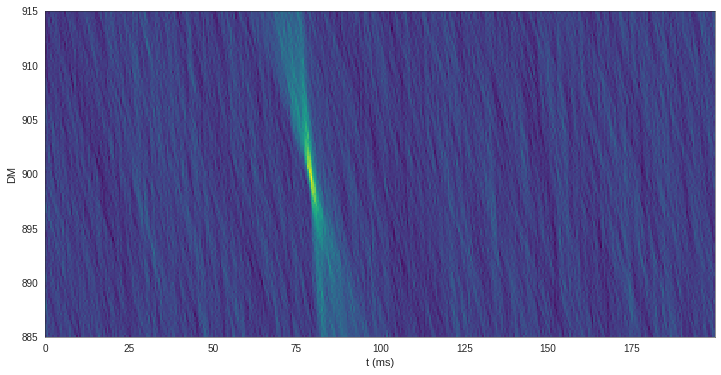

In [47]:
cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

tClipLow = 300. # (start) ms
tClipHigh = 200. # (width) ms
plt.imshow(np.flipud(dmSpaceArr[:,int((tClipLow/1000.)/tInt):int(((tClipLow+tClipHigh)/1000.)/tInt)]),\
           aspect='auto',\
           extent=(0, 1000.*tInt*int((tClipHigh/1000.)/tInt), minDM, maxDM),\
           cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('DM')
plt.xlabel('t (ms)')
#plt.colorbar(fraction=0.025)

In [48]:
# Low-res
timeFactor = 8

minDM = -1500
maxDM = 1500
dmStep = 8

start_time = 6. # seconds
time_window = 3. # seconds

applyGauss = True
fGauss = 2. # bins
tGauss = 2. # bins

rfi = [[805,820], [850,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

In [49]:
dmSpaceArrLow, tInt, freqs = frbutils.dmSpace(frbFil, start_time, time_window,
                                          minDM, maxDM, dmStep, timeFactor, rfi=rfi)

Maximum delay (ms) based on maximum DM (1500.000000): 1966.20538174


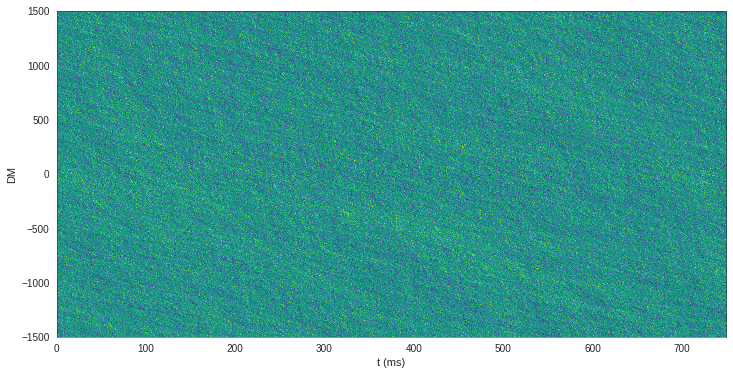

In [50]:
cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

tClipLow = 0. # (start) ms
tClipHigh = 750. # (width) ms
plt.imshow(np.flipud(dmSpaceArrLow[:,int((tClipLow/1000.)/tInt):int(((tClipLow+tClipHigh)/1000.)/tInt)]),\
           aspect='auto',\
           extent=(0, 1000.*tInt*int((tClipHigh/1000.)/tInt), minDM, maxDM),\
           cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('DM')
plt.xlabel('t (ms)')
#plt.colorbar(fraction=0.025)

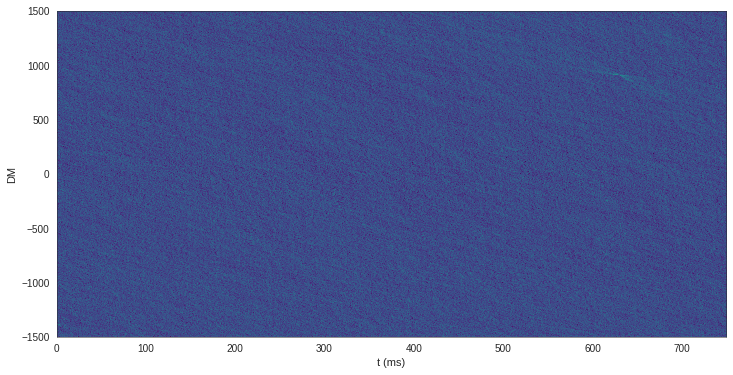

In [51]:
cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

tClipLow = 750. # (start) ms
tClipHigh = 750. # (width) ms
plt.imshow(np.flipud(dmSpaceArrLow[:,int((tClipLow/1000.)/tInt):int(((tClipLow+tClipHigh)/1000.)/tInt)]),\
           aspect='auto',\
           extent=(0, 1000.*tInt*int((tClipHigh/1000.)/tInt), minDM, maxDM),\
           cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('DM')
plt.xlabel('t (ms)')
#plt.colorbar(fraction=0.025)

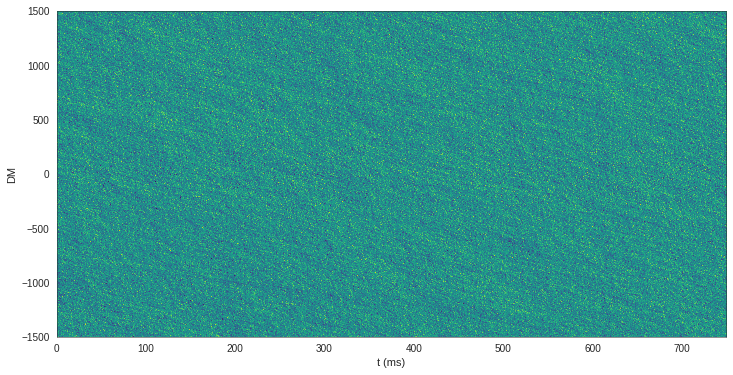

In [52]:
cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

tClipLow = 1500. # (start) ms
tClipHigh = 750. # (width) ms
plt.imshow(np.flipud(dmSpaceArrLow[:,int((tClipLow/1000.)/tInt):int(((tClipLow+tClipHigh)/1000.)/tInt)]),\
           aspect='auto',\
           extent=(0, 1000.*tInt*int((tClipHigh/1000.)/tInt), minDM, maxDM),\
           cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('DM')
plt.xlabel('t (ms)')
#plt.colorbar(fraction=0.025)

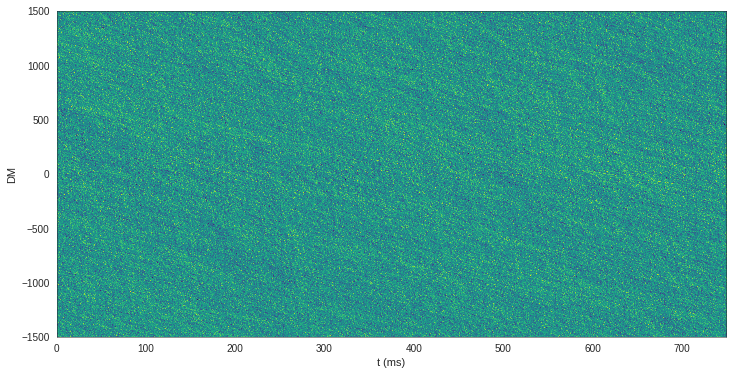

In [53]:
cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

tClipLow = 2250. # (start) ms
tClipHigh = 750. # (width) ms
plt.imshow(np.flipud(dmSpaceArrLow[:,int((tClipLow/1000.)/tInt):int(((tClipLow+tClipHigh)/1000.)/tInt)]),\
           aspect='auto',\
           extent=(0, 1000.*tInt*int((tClipHigh/1000.)/tInt), minDM, maxDM),\
           cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('DM')
plt.xlabel('t (ms)')
#plt.colorbar(fraction=0.025)

In [54]:
# No other bright regions in the DM trial space
# No obvious bias in positive or negative DM trial
criteria['dmSpace'] = 'POSITIVE'

### Dispersion Relation

In [55]:
### dynamic spectrum parameters
timeFactor = 1
freqFactor = 1
dm = 899.5

start_time = 7.3 # seconds
time_window = 1.5 # seconds

applyGauss = True
fGauss = 4. # bins
tGauss = 4. # bins

rfi = [[805,820], [850,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

normalize = False

In [56]:
decwaterfall, decddwaterfall, tInt, freqs = frbutils.dynamicSpectrum(frbFil, start_time, time_window,
                                                timeFactor=timeFactor, freqFactor=freqFactor,
                                                dm=dm,
                                                applyGauss=applyGauss, fGauss=fGauss, tGauss=tGauss,
                                                rfi=rfi)

In [57]:
ddTimeSeries = np.mean(decddwaterfall, axis=1)
startIdx = np.argmax(ddTimeSeries)
startTime = startIdx * tInt # seconds

In [58]:
if normalize:
    meanGain = np.median(decwaterfall, axis=1)
    decwaterfall = decwaterfall / meanGain[:, None]

    meanBP = np.mean(decwaterfall, axis=0)
    decwaterfall = decwaterfall / meanBP[None, :]

1078 1391


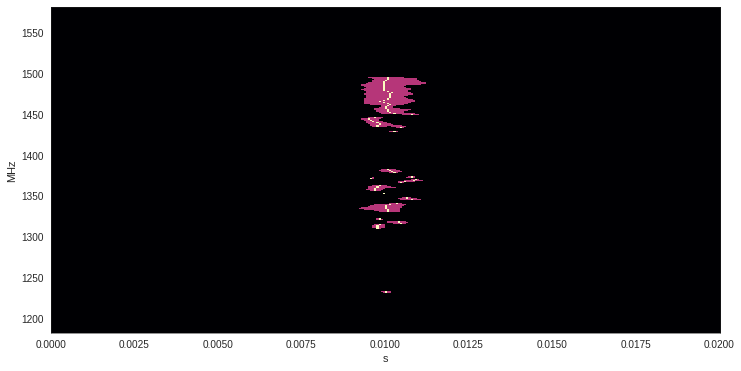

In [59]:
# Find peaks in dedispersed dynamic spectrum
# assuming a near nu^-2 relation, but pick a wide region to allow for variation
peakSearchWidth = .02 # s, time width to find peaks
peakStartTime = startTime - (peakSearchWidth / 2.)
peakStartIdx = int(peakStartTime / tInt)
peakStopTime = startTime + (peakSearchWidth / 2.)
peakStopIdx = int(peakStopTime / tInt)
print peakStartIdx, peakStopIdx

cutoutDynamicSpectrum = np.copy(decddwaterfall[peakStartIdx:peakStopIdx].T)
cutoutDynamicSpectrum -= np.mean(cutoutDynamicSpectrum)

snrThresh = 3.
stdDSpec = np.std(cutoutDynamicSpectrum)

delays = dedispersion.delay(freqs * 1e6, dm) # seconds
#print delays

binaryMask = np.where(cutoutDynamicSpectrum > snrThresh * stdDSpec, 0.5, 0)

validFidx = []
validTidx = []
validDelays = []
validSNR = []

for fIdx in np.arange(cutoutDynamicSpectrum.shape[0]): # loop over frequency channels
    subband = cutoutDynamicSpectrum[fIdx]
    # select only pixels above a threshold
    subPeakIdx = np.argmax(subband)
    if (subband[subPeakIdx] > snrThresh * stdDSpec):
        binaryMask[fIdx, subPeakIdx] = 1.
        validFidx.append(fIdx)
        validTidx.append(subPeakIdx)
        validSNR.append(subband[subPeakIdx] / stdDSpec)

validFreqs = freqs[validFidx]
validDelays = (np.array(validTidx) * tInt) - (peakSearchWidth / 2.) + delays[validFidx] + startTime
validSNR = np.array(validSNR)
#print validFreqs # MHz
#print validDelays # seconds
#print validSNR

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

imRaw = plt.imshow(np.flipud(binaryMask), extent=(0, tInt*cutoutDynamicSpectrum.shape[1],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('MHz')
plt.xlabel('s')

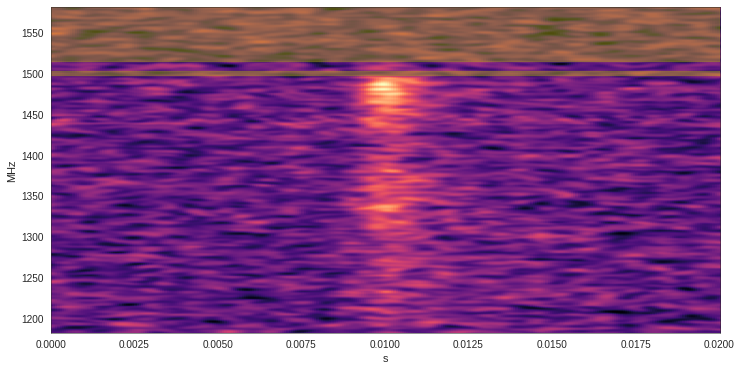

In [60]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

imRaw = plt.imshow(np.flipud(cutoutDynamicSpectrum), extent=(0, tInt*cutoutDynamicSpectrum.shape[1],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')
plt.xlabel('s')

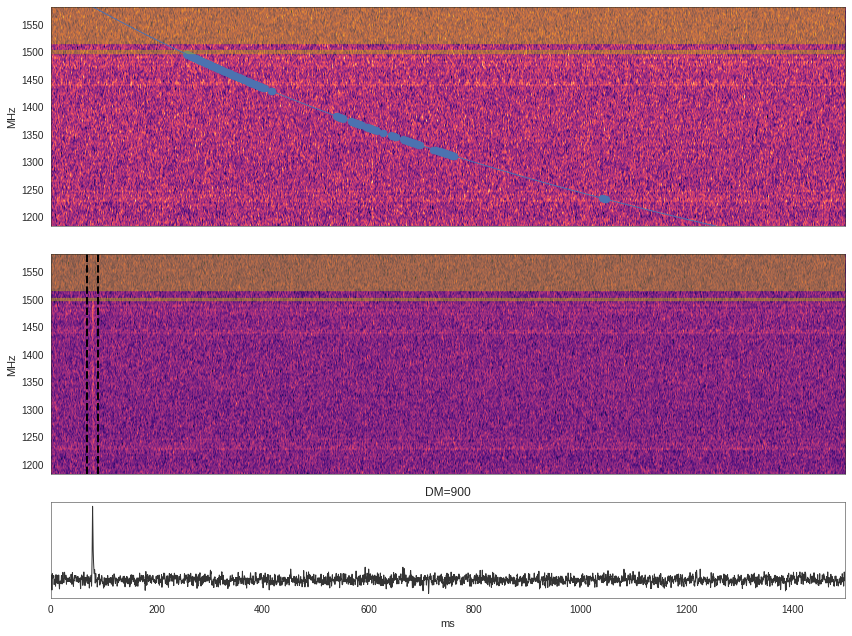

In [61]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,9)) # (width, height)

ax1 = plt.subplot2grid((5, 3), (0, 0), colspan=3, rowspan=2)

imRaw = plt.imshow(np.flipud(decwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

plt.plot(((dm * (4.15 * (10.**6) * (freqs**(-2.) - freqs[-1]**(-2.))))/1000.) + startTime, freqs)

plt.scatter(validDelays, validFreqs)

ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((5, 3), (2, 0), colspan=3, rowspan=2)

imRaw = plt.imshow(np.flipud(decddwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.axvline(x=peakStartTime, c='k', lw=2, ls='--')
plt.axvline(x=peakStopTime, c='k', lw=2, ls='--')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

ax2.get_xaxis().set_visible(False)

ax3 = plt.subplot2grid((5, 3), (4, 0), colspan=3)
lineColor = 'k'
plt.plot(1000.*tInt*np.arange(decddwaterfall.shape[0]), ddTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
plt.title('DM=%0.f'%dm)
plt.xlabel('ms')
ax3.get_yaxis().set_visible(False)

plt.tight_layout()

#### Build Power Law Model

In [62]:
model = lmfit.models.ExpressionModel('amp * (nu1**(alpha) - nu2**(alpha)) - toff', independent_vars=['nu1', 'nu2'])

print model
print model.param_names
print model.independent_vars

<lmfit.ExpressionModel('amp * (nu1**(alpha) - nu2**(alpha)) - toff')>
['amp', 'alpha', 'toff']
['nu1', 'nu2']


In [63]:
nu1 = validFreqs.copy()
nu2 = np.ones_like(validFreqs) * freqs[-1]

In [64]:
params = model.make_params(amp=dm * 4.148808e3, alpha=-2., toff=-1.*startTime)
#params['alpha'].set(min=-2.5, max=-1.5)
print params

Parameters([('amp', <Parameter 'amp', 3731852.796, bounds=[-inf:inf]>), ('alpha', <Parameter 'alpha', -2.0, bounds=[-inf:inf]>), ('toff', <Parameter 'toff', -0.079039999999999999, bounds=[-inf:inf]>)])


In [65]:
#print model.eval(params, nu1=nu1, nu2=nu2)
#print validDelays

In [66]:
out  = model.fit(validDelays, params, nu1=nu1, nu2=nu2, weights=validSNR)
print out.fit_report()

[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # function evals   = 50
    # data points      = 286
    # variables        = 3
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -3925.670
    Bayesian info crit = -3914.702
[[Variables]]
    amp:     3.5693e+06 +/- 8.60e+04 (2.41%) (init= 3731853)
    alpha:  -1.99335924 +/- 0.003575 (0.18%) (init=-2)
    toff:   -0.07883087 +/- 8.49e-05 (0.11%) (init=-0.07904)
[[Correlations]] (unreported correlations are <  0.100)
    C(amp, alpha)                = -1.000 
    C(alpha, toff)               =  0.925 
    C(amp, toff)                 = -0.924 



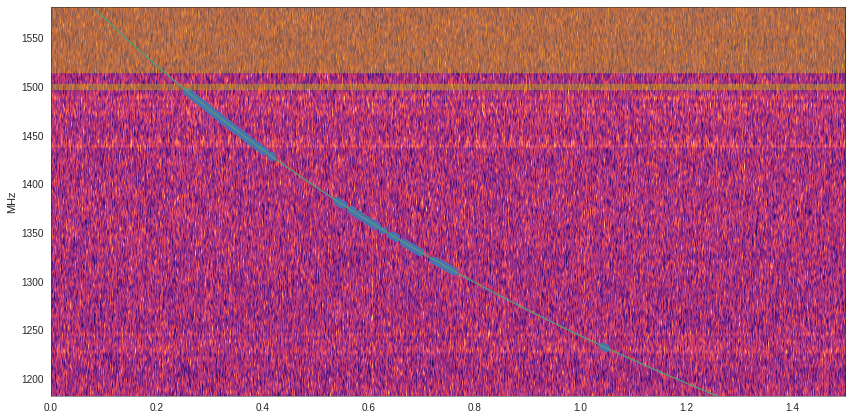

In [67]:
alphaBest = out.best_values['alpha']
ampBest = out.best_values['amp']
toffBest = out.best_values['toff']
nu1Full = freqs
nu2Full = freqs[-1]

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

imRaw = plt.imshow(np.flipud(decwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

plt.plot(((dm * (4.15 * (10.**6) * (freqs**(-2.) - freqs[-1]**(-2.))))/1000.) + startTime, freqs)
plt.plot(ampBest * (nu1Full**(alphaBest) - nu2Full**(alphaBest)) - toffBest, freqs)


plt.scatter(validDelays, validFreqs)

plt.tight_layout()

In [68]:
# Fits well to a nu^-2 dispersion relation
criteria['dispersionRelation'] = 'POSITIVE'

### Telescope Response

In [71]:
#offFrbFil = '/local/griffin/data/FRB/FRB090625/FRB090625_s0r10b8_b06.fil' # beam 6, ~3 minutes earlier
offFrbFil = '/home/griffin/data/FRB/FRB090625/FRB090625_s0r10b8_b06.fil' # beam 6, ~3 minutes earlier

onFil = filterbankio.Filterbank(frbFil)
ontInt = onFil.header['tsamp'] # get tInt
onFreqsHz = onFil.freqs * 1e6 # generate array of freqs in Hz
onFreqs = onFreqsHz / 1e6 # MHz
onWaterfall = np.reshape(onFil.data, (onFil.data.shape[0], onFil.data.shape[2]))

offFil = filterbankio.Filterbank(offFrbFil)
offtInt = offFil.header['tsamp'] # get tInt
offFreqsHz = offFil.freqs * 1e6 # generate array of freqs in Hz
offWaterfall = np.reshape(offFil.data, (offFil.data.shape[0], offFil.data.shape[2]))

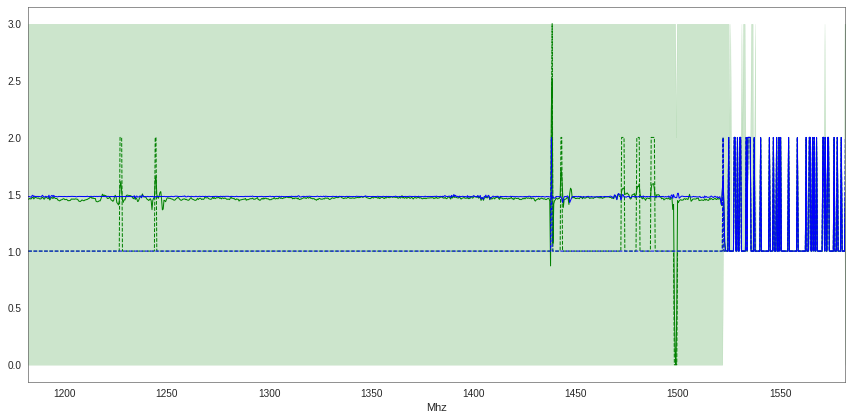

In [72]:
# Bandpass

onMeanBP = onWaterfall.mean(axis=0)
onMinBP = onWaterfall.min(axis=0)
onMaxBP = onWaterfall.max(axis=0)
onMedianBP = np.median(onWaterfall, axis=0)

offMeanBP = offWaterfall.mean(axis=0)
offMinBP = offWaterfall.min(axis=0)
offMaxBP = offWaterfall.max(axis=0)
offMedianBP = np.median(offWaterfall, axis=0)

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

plt.plot(onFreqs, onMeanBP, 'g-')
plt.plot(onFreqs, onMedianBP, 'g--')
#plt.plot(onFreqs, onMinBP, 'g.')
#plt.plot(onFreqs, onMaxBP, 'g.-')
plt.fill_between(onFreqs, onMinBP, onMaxBP, color='g', alpha=0.2)

plt.plot(onFreqs, offMeanBP, 'b-')
plt.plot(onFreqs, offMedianBP, 'b--')
#plt.plot(onFreqs, offMinBP, 'b.')
#plt.plot(onFreqs, offMaxBP, 'b.-')

plt.xlim(onFreqs[0], onFreqs[-1])
plt.xlabel('Mhz')

plt.tight_layout()

In [73]:
criteria['bandpass'] = 'UNKNOWN' # data has been bandpass normalized

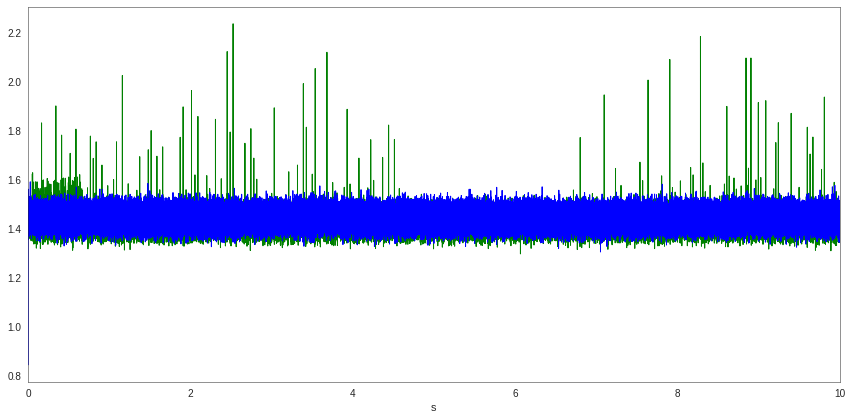

In [74]:
# Gain

onMeanGain = onWaterfall.mean(axis=1)
onMinGain = onWaterfall.min(axis=1)
onMaxGain = onWaterfall.max(axis=1)
onMedianGain = np.median(onWaterfall, axis=1)

offMeanGain = offWaterfall.mean(axis=1)
offMinGain = offWaterfall.min(axis=1)
offMaxGain = offWaterfall.max(axis=1)
offMedianGain = np.median(offWaterfall, axis=1)

tRange = np.arange(onMeanGain.shape[0]) * ontInt

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

plt.plot(tRange, onMeanGain, 'g-')
#plt.plot(onFreqs, onMedianGain, 'g--')
#plt.plot(onFreqs, onMinGain, 'g.')
#plt.plot(onFreqs, onMaxGain, 'g.-')
#plt.fill_between(onFreqs, onMinGain, onMaxGain, color='g', alpha=0.2)

plt.plot(tRange, offMeanGain, 'b-')
#plt.plot(onFreqs, offMedianGain, 'b--')
#plt.plot(onFreqs, offMinGain, 'b.')
#plt.plot(onFreqs, offMaxGain, 'b.-')

plt.xlim(0, onMeanGain.shape[0] * ontInt)
plt.xlabel('s')

plt.tight_layout()

In [75]:
criteria['gain'] = 'UNKNOWN' # data has been gain normalized

### Telescope State

In [76]:
# Telescope pointing

eventUTCStr = '2009-06-25 21:53:51.379'
eventUTC = astropy.time.Time(eventUTCStr)
print eventUTC

eventGall = 226.444
eventGalb = -60.0303

galCoords = astropy.coordinates.SkyCoord(eventGall, eventGalb, frame=astropy.coordinates.Galactic,\
                                         unit='deg', equinox='J2000')
print galCoords

# Parkes location
# https://www.parkes.atnf.csiro.au/observing/documentation/user_guide/pks_ug_2.html
siteLat = -32.99778
siteLong = 148.26292
siteLoc = astropy.coordinates.EarthLocation(lat=siteLat * astropy.units.deg, lon=siteLong * astropy.units.deg,\
                                  height=414.80 * astropy.units.m)
print siteLoc

print galCoords.transform_to(astropy.coordinates.AltAz(obstime=eventUTC, location=siteLoc))

print galCoords.transform_to('icrs')

2009-06-25 21:53:51.379
<SkyCoord (Galactic): (l, b) in deg
    ( 226.444, -60.0303)>
(-4554234.701509818, 2816825.9185967753, -3453978.054094455) m
<SkyCoord (AltAz: obstime=2009-06-25 21:53:51.379, location=(-4554234.701509818, 2816825.9185967753, -3453978.054094455) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0, obswl=1.0 micron): (az, alt) in deg
    ( 81.5913608,  75.89128708)>
<SkyCoord (ICRS): (ra, dec) in deg
    ( 46.94584178, -29.92670987)>


In [77]:
criteria['lowAltitude'] = 'POSITIVE' # high-altitude pointing

In [78]:
#criteria['sysNoise'] = 'UNKNOWN' # system noise nominal?
#criteria['correctFeed'] = 'UNKNOWN' # was the feed in the corrct position?
#criteria['obsLog'] = 'UNKNOWN' # was the observation log checked to be nominal?
#criteria['electronics'] = 'UNKNOWN' # were the correct electornics on? were other systems off?
criteria['telState'] = 'UNKNOWN'
criteria['rfi'] = 'UNKNOWN'

### Follow-Up Observations

In [79]:
# Unknown if follow-up observations or a pulsar search were done
criteria['repeats'] = 'UNKNOWN'
criteria['lowSNRsearch'] = 'UNKNOWN'

### Multi-Beam

In [80]:
### dynamic spectrum parameters
timeFactor = 1
freqFactor = 1
dm = 899.5

start_time = 7.3 # seconds
time_window = 0.15 # seconds

applyGauss = True
fGauss = 4. # bins
tGauss = 4. # bins

rfi = [[805,820], [850,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

In [81]:
def multiBeamPlot():
    decwaterfallBeam, decddwaterfallBeam, tInt, freqs = frbutils.dynamicSpectrum(frbFilBeam,
                                          start_time, time_window,
                                          timeFactor=timeFactor, freqFactor=freqFactor,
                                          dm=dm,
                                          applyGauss=applyGauss, fGauss=fGauss, tGauss=tGauss,
                                          rfi=rfi)

    ddTimeSeriesBeam = np.mean(decddwaterfallBeam, axis=1)

    cmap = 'magma'
    sns.set_style('white', rc={'axes.linewidth': 0.5})

    fig = plt.figure(figsize=(12,6)) # (width, height)

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)

    imRaw = plt.imshow(np.flipud(decddwaterfallBeam.T), extent=(0, tInt*decddwaterfallBeam.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
    # crop out RFI flagged high freqs
    #imRaw = plt.imshow(np.flipud(decddwaterfallBeam[:,:850].T), extent=(0, tInt*decddwaterfallBeam.shape[0],\
    #                    freqs[0], freqs[850]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

    for rfiPair in rfi:
        plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
    plt.ylabel('MHz')

    ax1.get_xaxis().set_visible(False)

    ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
    lineColor = 'k'
    plt.plot(1000.*tInt*np.arange(decddwaterfallBeam.shape[0]), ddTimeSeriesBeam, lineColor, alpha=0.8)
    plt.plot(1000.*tInt*np.arange(decddwaterfall.shape[0]), ddTimeSeries, 'r', alpha=0.4) # pulse time series
    plt.xlim(0, 1000.*tInt*ddTimeSeriesBeam.shape[0])
    plt.title('DM=%0.f'%dm)
    plt.xlabel('ms')
    ax2.get_yaxis().set_visible(False)

    plt.tight_layout()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b01.fil' # beam 01 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b02.fil' # beam 02 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b03.fil' # beam 03 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b04.fil' # beam 04 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b05.fil' # beam 05 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b06.fil' # beam 06 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b07.fil' # beam 07 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b08.fil' # beam 08 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b09.fil' # beam 09 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b10.fil' # beam 10 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b11.fil' # beam 11 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b12.fil' # beam 12 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b13.fil' # beam 13 (aslxlap07)
multiBeamPlot()

In [82]:
# No pulse present in any of the other beams, possibly present in beam 12
criteria['multiBeam'] = 'POSITIVE'

### Tied-Array Beam

In [83]:
criteria['TAB'] = 'NOTVALID'

### Interferometric Observations

In [84]:
criteria['interferometric'] = 'NOTVALID'

### Multi-Site

In [85]:
criteria['multiSite'] = 'NOTVALID'

### Available Data

In [86]:
criteria['dataSingleBeam'] = 'NOTVALID'
criteria['dataMultiBeam'] = 'NEUTRAL' # filterbanks have been normalized
criteria['dataTAB'] = 'NOTVALID'
criteria['dataInterferometric'] = 'NOTVALID'
criteria['dataMultiSite'] = 'NOTVALID'
criteria['dataVoltages'] = 'NOTVALID'

### Report Output

In [87]:
for key in criteria.iterkeys():
    print '%s: %s'%(key, criteria[key])

outFn = 'criteria.%s.pkl'%frbStr
ofh = open(outFn, 'wb')
pkl.dump(criteria, ofh)
ofh.close()

dataInterferometric: NOTVALID
multiSite: NOTVALID
multicomp: POSITIVE
lowAltitude: POSITIVE
scattering: POSITIVE
spectralIndex: NEUTRAL
flux: POSITIVE
broadband: POSITIVE
multiBeam: POSITIVE
polarization: NOTVALID
pulsewidth: POSITIVE
DMexcess: POSITIVE
TAB: NOTVALID
dispersionRelation: POSITIVE
telState: UNKNOWN
interferometric: NOTVALID
gain: UNKNOWN
dataVoltages: NOTVALID
dataMultiBeam: NEUTRAL
dataTAB: NOTVALID
dmSpace: POSITIVE
lowSNRsearch: UNKNOWN
dataMultiSite: NOTVALID
highResStruct: POSITIVE
SNR: POSITIVE
rfi: UNKNOWN
repeats: UNKNOWN
scintillation: NEUTRAL
bandpass: UNKNOWN
dataSingleBeam: NOTVALID
